In [324]:
import pandas as pd
import gensim
import opencorpora
from pymystem3 import Mystem
from many_stop_words import get_stop_words
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [325]:
code = pd.read_csv('data/criminal_code.csv')
df = pd.read_csv('data/judicial_orders.csv').rename(columns={'title':'name'})
code['lemmas'] = code['lemmas'].map(eval)
df['lemmas'] = df['lemmas'].map(eval)

## Статьи кодекса и судебные решения

In [326]:
code['is_code'] = 1
df['is_code'] = 0

In [327]:
tmp = pd.concat([
    code[['name', 'lemmas','is_code']], 
    df[['name', 'lemmas', 'is_code']]
], ignore_index=True)

In [328]:
td = lambda row: gensim.models.doc2vec.TaggedDocument(
    words=row['lemmas'], 
    tags=[row.name]
)
documents = tmp.apply(td, axis=1).tolist()

In [329]:
%%time
model = gensim.models.doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.025)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=100)

CPU times: user 22min 18s, sys: 24.2 s, total: 22min 42s
Wall time: 8min 28s


In [330]:
docvec = dict(zip(model.docvecs.offset2doctag, model.docvecs.vectors_docs.tolist()))

In [331]:
tmp['vectors'] = model.docvecs.vectors_docs.tolist()

In [332]:
tmp['pca'] = PCA(n_components=2).fit_transform(tmp['vectors'].tolist()).tolist()

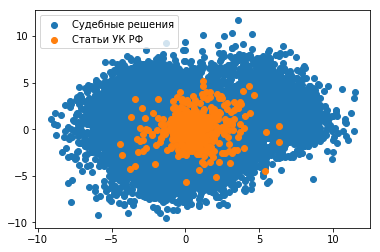

In [333]:
plt.scatter(
    x=tmp[tmp['is_code'] == 0]['pca'].map(lambda x: x[0]),
    y=tmp[tmp['is_code'] == 0]['pca'].map(lambda x: x[1]),
    label='Судебные решения'
)
plt.scatter(
    x=tmp[tmp['is_code'] == 1]['pca'].map(lambda x: x[0]),
    y=tmp[tmp['is_code'] == 1]['pca'].map(lambda x: x[1]),
    label='Статьи УК РФ'
)
plt.legend()
pass

In [360]:
import re
patt = re.compile("\\n|\\t|\\r")
clean_str = lambda s: re.sub(patt, ' ', s)

In [362]:
tmp['name'] = tmp['name'].map(clean_str)

In [363]:
tmp.drop(['lemmas'], axis=1).to_csv('results/doc2vec_all.csv', index=False)

### Вместе с opencorpora

In [364]:
reader = opencorpora.CorpusReader('data/opencorpora/annot.opcorpora.xml')

In [368]:
m = Mystem(entire_input=False)

In [369]:
def lemm_and_filter(text, stopwords=get_stop_words('ru')):
    lemmas = m.lemmatize(text)
    filter_cond = lambda word: word not in stopwords and len(word) > 3
    return list(filter(filter_cond, lemmas))

In [370]:
%%time
docs_iter = reader.iter_documents()
corpus = [(doc.title(), doc.raw(), lemm_and_filter(doc.raw())) for doc in docs_iter]

CPU times: user 3min 51s, sys: 9.07 s, total: 4min
Wall time: 5min 24s


In [371]:
tmp = pd.DataFrame(corpus, columns=['name', 'body', 'lemmas'])

In [372]:
tmp = tmp.drop(tmp[tmp['lemmas'].map(len) == 0].index)

In [373]:
tmp['source'] = 'opencorpora'
code['source'] = 'criminal_code'
df['source'] = 'judgement'

In [374]:
tmp = pd.concat([
    tmp,
    code[['name', 'body', 'lemmas', 'source']],
    df.rename(columns={'case':'body'})[['name', 'body', 'lemmas', 'source']]
], ignore_index=True)

In [376]:
td = lambda row: gensim.models.doc2vec.TaggedDocument(
    words=row['lemmas'], 
    tags=[row.name]
)
documents = tmp.apply(td, axis=1).tolist()

In [377]:
%%time
model = gensim.models.doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.025)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=100)

CPU times: user 26min 49s, sys: 34 s, total: 27min 23s
Wall time: 10min 23s


In [378]:
tmp['name'] = tmp['name'].map(clean_str)

In [379]:
tmp['vectors'] = model.docvecs.vectors_docs.tolist()
tmp.drop(['lemmas', 'body'], axis=1).to_csv('results/doc2vec_with_opencorpora.csv', index=False)

In [380]:
tmp['pca'] = PCA(n_components=2).fit_transform(tmp['vectors'].tolist()).tolist()

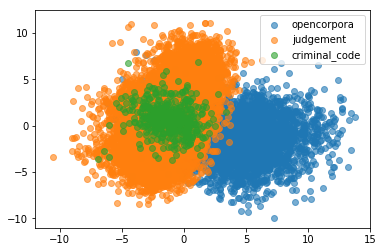

In [381]:
for source in ['opencorpora', 'judgement', 'criminal_code']:
    plt.scatter(
        x=tmp[tmp['source'] == source]['pca'].map(lambda x: x[0]),
        y=tmp[tmp['source'] == source]['pca'].map(lambda x: x[1]),
        label=source, 
        alpha=.6)
plt.legend()
pass

In [382]:
tmp_500 = pd.concat([
    tmp[tmp['source'] == 'opencorpora'].sample(500),
    tmp[tmp['source'] == 'judgement'].sample(500),
    tmp[tmp['source'] == 'criminal_code']
], ignore_index=True)[['name', 'source', 'vectors']]

In [383]:
tmp_500.to_csv('results/doc2vec_light.csv', index=False)

## Используя фразы

In [386]:
phraser = gensim.models.phrases.Phraser(gensim.models.phrases.Phrases(sentences=tmp['lemmas']))

In [388]:
td = lambda row: gensim.models.doc2vec.TaggedDocument(
    words=phraser[row['lemmas']], 
    tags=[row.name]
)
documents = tmp.apply(td, axis=1).tolist()

In [390]:
%%time
model = gensim.models.doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.025)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=100)

CPU times: user 23min 39s, sys: 45.3 s, total: 24min 25s
Wall time: 9min 49s


In [391]:
tmp['name'] = tmp['name'].map(clean_str)
tmp['vectors'] = model.docvecs.vectors_docs.tolist()
tmp.drop(['lemmas', 'body'], axis=1).to_csv('results/doc2vec_phrases.csv', index=False)

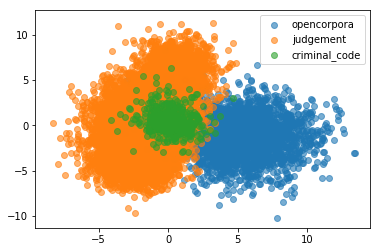

In [392]:
tmp['pca'] = PCA(n_components=2).fit_transform(tmp['vectors'].tolist()).tolist()
for source in ['opencorpora', 'judgement', 'criminal_code']:
    plt.scatter(
        x=tmp[tmp['source'] == source]['pca'].map(lambda x: x[0]),
        y=tmp[tmp['source'] == source]['pca'].map(lambda x: x[1]),
        label=source, 
        alpha=.6)
plt.legend()
pass

In [393]:
tmp_500 = pd.concat([
    tmp[tmp['source'] == 'opencorpora'].sample(500),
    tmp[tmp['source'] == 'judgement'].sample(500),
    tmp[tmp['source'] == 'criminal_code']
], ignore_index=True)

In [396]:
tmp_500.drop(['body', 'lemmas', 'pca'], axis=1)\
        .to_csv('results/doc2vec_phrases_light.csv', index=False)